In [1]:
import os
import sys
import pickle

import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# turn off dark mode
plt.style.use('default')

from tqdm import tqdm

In [2]:
class StockReturnsDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame) -> None:
        super().__init__()
        # preprocess dataset
        self.returns = dataset.pct_change(1, fill_method="ffill")[1:]

    def __len__(self):
        return len(self.returns) - 1

    def __getitem__(self, index):
        i, j = self.returns.index[index], self.returns.index[index + 1]
        x = self.returns.loc[i].values
        y = self.returns.loc[j].values

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        return x, y

In [33]:
with open("train_dataset.pkl", "rb") as f:
    train_df = pickle.load(f)

train_df = train_df['Adj Close'] # market close value
train_df = train_df.fillna(method='ffill') # attempt to fill nan values
train_df = train_df.dropna(axis=1) # remove stocks with nan values that couldn't be filled

assert pd.isna(train_df).any().sum() == 0

stocks = train_df.columns # stocks to keep without nan values

with open("test_dataset.pkl", "rb") as f:
    test_df = pickle.load(f)

test_df = test_df['Adj Close']
test_df = test_df[stocks]

assert pd.isna(test_df).any().sum() == 0

In [34]:
train_dataset = StockReturnsDataset(train_df)
test_dataset = StockReturnsDataset(test_df)

print("train dataset length", len(train_dataset))
print("test dataset length", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

x,y = next(iter(train_loader))
x.shape, y.shape

train dataset length 1234
test dataset length 19


(torch.Size([16, 493]), torch.Size([16, 493]))

In [98]:
class RRNet(torch.nn.Module):
    def __init__(self, dim, depth, activation=torch.nn.ReLU, dropout=0.3) -> None:
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.activation = activation
        self.dropout = dropout

        _mlps = []
        for _ in range(depth):
            _mlps.append(torch.nn.Linear(dim, dim))
            _mlps.append(activation())
            _mlps.append(torch.nn.Dropout(dropout))
        _mlps.append(torch.nn.Linear(dim, dim)) # last layer without activation
        self.mlps = torch.nn.Sequential(*_mlps)

    def forward(self, x):
        # forward pass with skip connection
        # return x + self.mlps(x)
        x = self.mlps(x)

        # s = x.sum(dim=1)
        # s = s.unsqueeze(1).repeat(1, self.dim)
        # x = x / s # normalize sum=1

        x = torch.nn.functional.normalize(x, dim=1, p=2)
        return x

In [90]:
def num_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

In [103]:
dim = len(stocks)
network_depth = 6

net = RRNet(dim=dim, depth=network_depth, activation=torch.nn.ReLU, dropout=0.3)

print("number of parameters:", num_params(net))
net

number of parameters: 1704794


RRNet(
  (mlps): Sequential(
    (0): Linear(in_features=493, out_features=493, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=493, out_features=493, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=493, out_features=493, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=493, out_features=493, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=493, out_features=493, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=493, out_features=493, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18): Linear(in_features=493, out_features=493, bias=True)
  )
)

In [100]:
def test_model(model, loader):
    """
    using the network predicted returns to evaluate the model
    """
    R = []
    with torch.no_grad():
        for x, y in loader:
            w = model(x)
            r = (w * y).sum(dim=1).mean()
            R.append(r.item())
    return np.nanmean(R), np.nanstd(R)

test_model(net, test_loader)

(0.009431523270905018, 0.004421398043632507)

In [104]:
# training loop

EPOCHS = 20

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, maximize=True)
device = "cpu"

net.train()

test_return, test_std = [], []

for epoch in range(EPOCHS):
    running_return = 0.0
    print(f"epoch {epoch + 1}/{EPOCHS}")
    with tqdm(total=len(train_loader)) as progress:
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            # forward
            output = net(X)
            R = (output * y).sum(dim=1).mean()

            # backward
            optimizer.zero_grad()
            R.backward()
            optimizer.step()

            # print statistics
            # progress.set_postfix(R=R)
            progress.update()

    # evaluate on test set
    _r, _s = test_model(net, test_loader)
    test_return.append(_r)
    test_std.append(_s)

epoch 1/20


100%|██████████| 78/78 [00:03<00:00, 23.73it/s]


epoch 2/20


100%|██████████| 78/78 [00:02<00:00, 27.18it/s]


epoch 3/20


100%|██████████| 78/78 [00:03<00:00, 25.65it/s]


epoch 4/20


100%|██████████| 78/78 [00:02<00:00, 27.11it/s]


epoch 5/20


100%|██████████| 78/78 [00:02<00:00, 28.58it/s]


epoch 6/20


100%|██████████| 78/78 [00:02<00:00, 30.56it/s]


epoch 7/20


100%|██████████| 78/78 [00:02<00:00, 30.57it/s]


epoch 8/20


100%|██████████| 78/78 [00:02<00:00, 28.87it/s]


epoch 9/20


100%|██████████| 78/78 [00:02<00:00, 27.01it/s]


epoch 10/20


100%|██████████| 78/78 [00:03<00:00, 24.67it/s]


epoch 11/20


100%|██████████| 78/78 [00:03<00:00, 23.14it/s]


epoch 12/20


100%|██████████| 78/78 [00:03<00:00, 24.18it/s]


epoch 13/20


100%|██████████| 78/78 [00:03<00:00, 20.47it/s]


epoch 14/20


100%|██████████| 78/78 [00:04<00:00, 17.78it/s]


epoch 15/20


100%|██████████| 78/78 [00:03<00:00, 20.72it/s]


epoch 16/20


100%|██████████| 78/78 [00:04<00:00, 19.37it/s]


epoch 17/20


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch 18/20


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch 19/20


100%|██████████| 78/78 [00:05<00:00, 14.77it/s]


epoch 20/20


100%|██████████| 78/78 [00:03<00:00, 22.96it/s]


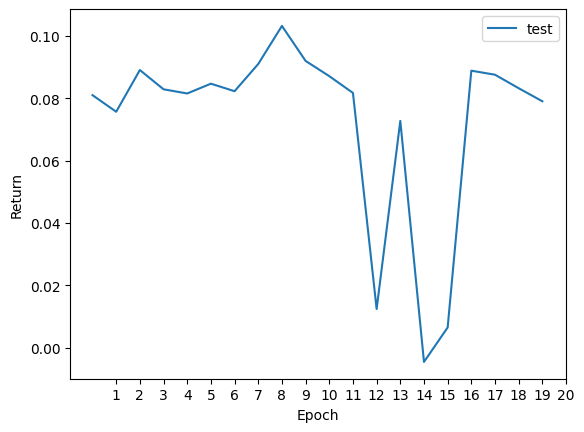

In [105]:
plt.plot(test_return, label="test")
plt.xticks(np.arange(1, EPOCHS+1, 1))
plt.ylabel("Return")
plt.xlabel("Epoch")
plt.legend()
plt.show()